<a href="https://colab.research.google.com/github/AnsiaNijas/DataMining/blob/main/Clustering_with_Plants_Dataset_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the neccessary Libraries**

In [157]:
!pip install kneed

In [158]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.express as px


**Load the Data**

In [159]:
# Load the main data file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data"
plants_data = pd.read_csv(url, header=None, delimiter='\t', encoding='latin-1')

# Display the first few rows
print("First 5 rows of the dataset:")
print(plants_data.head())

# Check for missing values
print("\nMissing Values:")
print(plants_data.isnull().sum())

# Display dataset information
print("\nDataset Info:")
print(plants_data.info())

First 5 rows of the dataset:
                                                   0
0                                       abelia,fl,nc
1                         abelia x grandiflora,fl,nc
2  abelmoschus,ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,s...
3  abelmoschus esculentus,ct,dc,fl,il,ky,la,md,mi...
4                        abelmoschus moschatus,hi,pr

Missing Values:
0    0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34781 entries, 0 to 34780
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       34781 non-null  object
dtypes: object(1)
memory usage: 271.9+ KB
None


**Handle missing values**

In [160]:
# Handle missing values (if applicable)
plants_data_cleaned = plants_data.dropna()

print("\nDataset after handling missing values:")
print(plants_data_cleaned.info())
print(plants_data_cleaned.head())


Dataset after handling missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34781 entries, 0 to 34780
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       34781 non-null  object
dtypes: object(1)
memory usage: 271.9+ KB
None
                                                   0
0                                       abelia,fl,nc
1                         abelia x grandiflora,fl,nc
2  abelmoschus,ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,s...
3  abelmoschus esculentus,ct,dc,fl,il,ky,la,md,mi...
4                        abelmoschus moschatus,hi,pr


**Preprocess the Data**

Step 1: Split the Columns:

Extract plant names and states into separate columns.                                                                                   

Step 2: One-Hot Encode State Information:

Convert state abbreviations into a binary feature matrix.

In [161]:
# Split plant names and states
plants_data_cleaned[['Plant Name', 'States']] = plants_data_cleaned[0].str.split(',', n=1, expand=True)

# Drop the original combined column
plants_data_cleaned = plants_data_cleaned.drop(columns=[0])

print(plants_data_cleaned.head())

# Split states into individual columns
states = plants_data_cleaned['States'].str.get_dummies(sep=',')

# Combine with the plant names for reference
processed_data = pd.concat([plants_data_cleaned['Plant Name'], states], axis=1)

print(processed_data.shape)
print(processed_data.head())



               Plant Name                                        States
0                  abelia                                         fl,nc
1    abelia x grandiflora                                         fl,nc
2             abelmoschus  ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,sc,va,pr,vi
3  abelmoschus esculentus     ct,dc,fl,il,ky,la,md,mi,ms,nc,sc,va,pr,vi
4   abelmoschus moschatus                                         hi,pr
(34781, 71)
               Plant Name  ab  ak  al  ar  az  bc  ca  co  ct  ...  tx  ut  \
0                  abelia   0   0   0   0   0   0   0   0   0  ...   0   0   
1    abelia x grandiflora   0   0   0   0   0   0   0   0   0  ...   0   0   
2             abelmoschus   0   0   0   0   0   0   0   0   1  ...   0   0   
3  abelmoschus esculentus   0   0   0   0   0   0   0   0   1  ...   0   0   
4   abelmoschus moschatus   0   0   0   0   0   0   0   0   0  ...   0   0   

   va  vi  vt  wa  wi  wv  wy  yt  
0   0   0   0   0   0   0   0   0  
1   0   0   0  

**Normalize the One-Hot Encoded Data :**
Normalize the binary state matrix for clustering

In [162]:
# Exclude plant names for clustering
state_matrix = states  # Use only the one-hot encoded state columns

# Normalize the state data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(state_matrix)

print(pd.DataFrame(scaled_data).head())



         0         1         2         3         4         5         6   \
0 -0.329588 -0.305499 -0.442817 -0.390891 -0.491981 -0.403746 -0.710876   
1 -0.329588 -0.305499 -0.442817 -0.390891 -0.491981 -0.403746 -0.710876   
2 -0.329588 -0.305499 -0.442817 -0.390891 -0.491981 -0.403746 -0.710876   
3 -0.329588 -0.305499 -0.442817 -0.390891 -0.491981 -0.403746 -0.710876   
4 -0.329588 -0.305499 -0.442817 -0.390891 -0.491981 -0.403746 -0.710876   

        7         8         9   ...        60       61        62        63  \
0 -0.43176 -0.380116 -0.311701  ... -0.567954 -0.45847 -0.439841 -0.258907   
1 -0.43176 -0.380116 -0.311701  ... -0.567954 -0.45847 -0.439841 -0.258907   
2 -0.43176  2.630775  3.208198  ... -0.567954 -0.45847  2.273550  3.862393   
3 -0.43176  2.630775  3.208198  ... -0.567954 -0.45847  2.273550  3.862393   
4 -0.43176 -0.380116 -0.311701  ... -0.567954 -0.45847 -0.439841 -0.258907   

         64        65        66        67        68        69  
0 -0.345705 -0.4

**Apply Dimensionality Reduction**

In [163]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.38319622 0.12197108]


**Use the Elbow Method to find the optimal number of clusters**

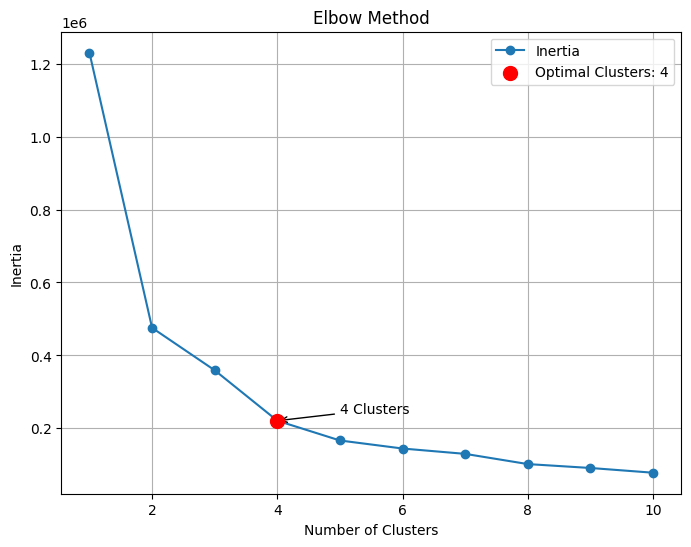

The optimal number of clusters is: 4


In [164]:
# Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

# Find the optimal number of clusters using KneeLocator
knee_locator = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', label="Inertia")
plt.scatter(optimal_clusters, inertia[optimal_clusters - 1], color='red', label=f'Optimal Clusters: {optimal_clusters}', s=100, zorder=5)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.legend()
plt.grid(True)

# Annotate the optimal point
plt.annotate(f"{optimal_clusters} Clusters",
             xy=(optimal_clusters, inertia[optimal_clusters - 1]),
             xytext=(optimal_clusters + 1, inertia[optimal_clusters - 1] + 20000),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_clusters}")


**Apply K-Means clustering**

In [165]:
# Apply K-Means to reduced data
kmeans_pca = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels_pca = kmeans_pca.fit_predict(reduced_data)

# Evaluate with reduced data
silhouette_pca = silhouette_score(reduced_data, kmeans_labels_pca)
print("Silhouette Score (Reduced Data):", silhouette_pca)
print("Inertia (Reduced Data):", kmeans_pca.inertia_)


Silhouette Score (Reduced Data): 0.6829698895893928
Inertia (Reduced Data): 220866.25931711233


**Visualize the Clusters (K-means)**

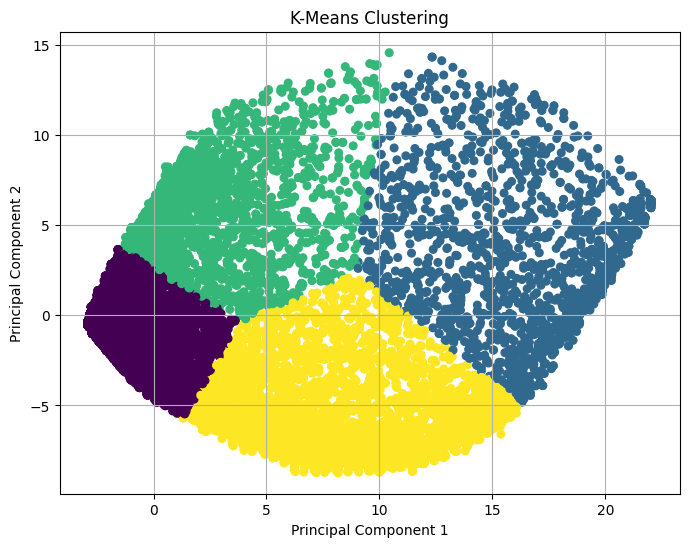

In [166]:
# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels_pca, cmap='viridis', s=30)
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


**Determine Optimal eps and min_samples for DBSCAN Clustering Using k-Distance Plot and Dimensionality Rule**

Elbow distance (Eps estimate): 0.5375096234960196
Suggested eps range: [0.4300077  0.45389702 0.47778633 0.50167565 0.52556497 0.54945428
 0.5733436  0.59723291 0.62112223 0.64501155]
Best parameters: {'eps': 0.6450115481952235, 'min_samples': 5}
Best silhouette score: 0.6655365822712718


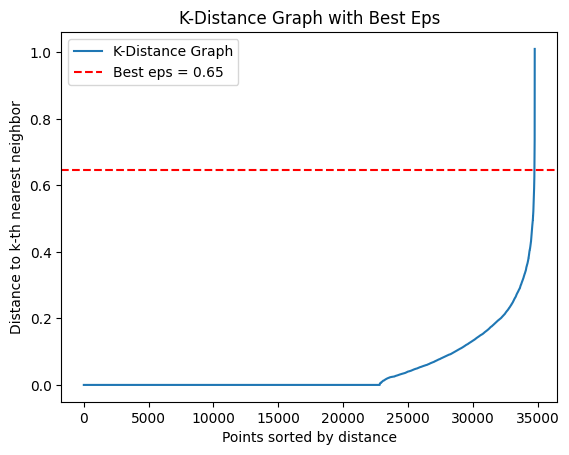

In [167]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Replace this with your actual dataset (2D array or similar)
data = reduced_data

# Step 1: KNN Distance Plot and Eps Range Selection
min_samples = 4  # Initial guess for min_samples
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)

# Sort distances to the k-th nearest neighbor
sorted_distances = np.sort(distances[:, -1])

# Use KneeLocator to find the elbow point
def find_eps_range(distances, factor=0.2):
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    elbow_distance = distances[knee_locator.knee]  # Eps estimate at the elbow point

    # Define the range of eps values around the estimated elbow distance
    eps_lower_bound = elbow_distance * (1 - factor)
    eps_upper_bound = elbow_distance * (1 + factor)
    eps_range = np.linspace(eps_lower_bound, eps_upper_bound, 10)
    return eps_range, elbow_distance

# Get eps range
eps_range, elbow_distance = find_eps_range(sorted_distances)
print(f"Elbow distance (Eps estimate): {elbow_distance}")
print(f"Suggested eps range: {eps_range}")

# Step 2: Grid Search for Optimal Eps and Min Samples
min_samples_range = [3, 5, 7, 10]  # Adjust as needed
best_score = -1
best_params = None

for eps in eps_range:
    for min_samples in min_samples_range:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        labels = db.labels_

        # Ignore configurations where all points are noise or single cluster
        if len(set(labels)) > 1:
            score = silhouette_score(data, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

# Mark the best eps in the graph
plt.plot(sorted_distances, label="K-Distance Graph")
plt.axhline(y=best_params['eps'], color='r', linestyle='--', label=f"Best eps = {best_params['eps']:.2f}")
plt.title('K-Distance Graph with Best Eps')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th nearest neighbor')
plt.legend()
plt.show()


**K-Distance graph and Elbow Plot**

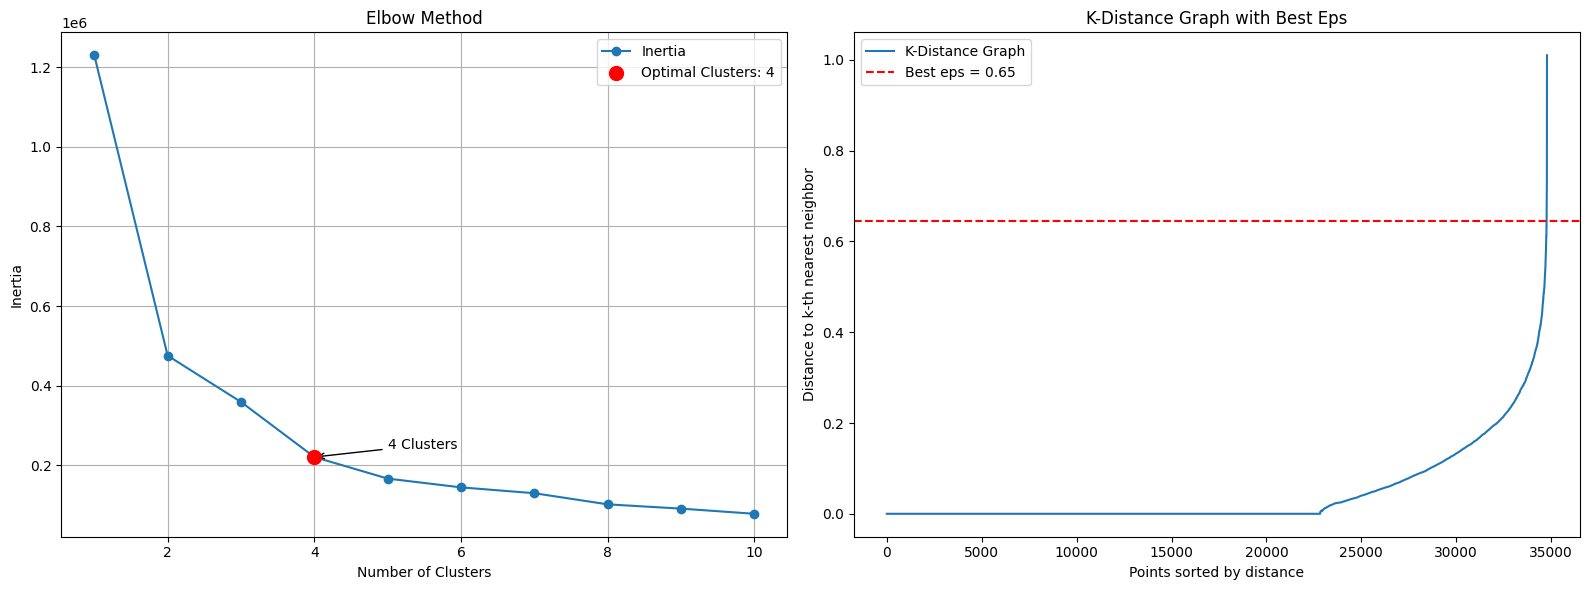

In [168]:
# Combined Subplots: Elbow Curve and K-Distance Graph
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Elbow Method for KMeans
axs[0].plot(range(1, 11), inertia, marker='o', label="Inertia")
axs[0].scatter(optimal_clusters, inertia[optimal_clusters - 1], color='red', label=f'Optimal Clusters: {optimal_clusters}', s=100, zorder=5)
axs[0].set_title("Elbow Method")
axs[0].set_xlabel("Number of Clusters")
axs[0].set_ylabel("Inertia")
axs[0].legend()
axs[0].grid(True)
axs[0].annotate(f"{optimal_clusters} Clusters",
                xy=(optimal_clusters, inertia[optimal_clusters - 1]),
                xytext=(optimal_clusters + 1, inertia[optimal_clusters - 1] + 20000),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=10)

# Subplot 2: K-Distance Graph for DBSCAN
axs[1].plot(sorted_distances, label="K-Distance Graph")
axs[1].axhline(y=best_params['eps'], color='r', linestyle='--', label=f"Best eps = {best_params['eps']:.2f}")
axs[1].set_title('K-Distance Graph with Best Eps')
axs[1].set_xlabel('Points sorted by distance')
axs[1].set_ylabel('Distance to k-th nearest neighbor')
axs[1].legend()

plt.tight_layout()
plt.show()


**Apply DBSCAN**

In [169]:
# Apply DBSCAN with the recalculated eps and adjusted min_samples
dbscan_pca = DBSCAN(eps=eps, min_samples=min_samples)  # Adjusted min_samples for PCA dimensions
dbscan_labels_pca = dbscan_pca.fit_predict(reduced_data)

# Evaluate DBSCAN Results
n_clusters = len(set(dbscan_labels_pca)) - (1 if -1 in dbscan_labels_pca else 0)
n_noise = list(dbscan_labels_pca).count(-1)

print(f"Number of clusters (after PCA): {n_clusters}")
print(f"Number of noise points (after PCA): {n_noise}")


Number of clusters (after PCA): 10
Number of noise points (after PCA): 177


**Visualize Clusters**

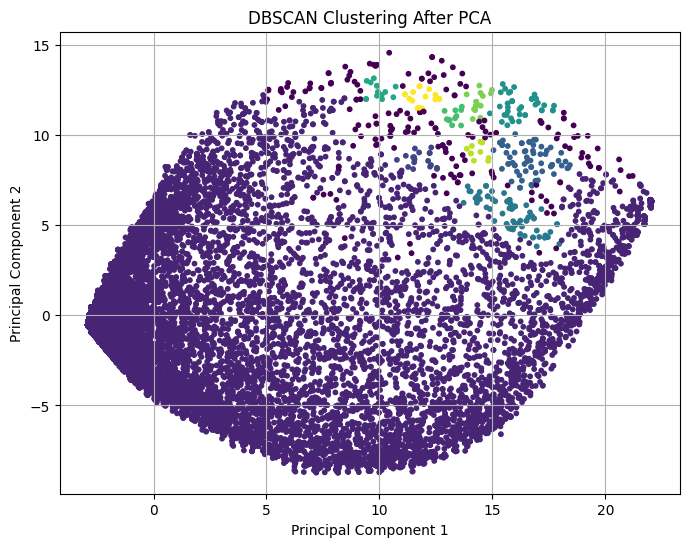

In [170]:
# Visualize Clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels_pca, cmap='viridis', s=10)
plt.title("DBSCAN Clustering After PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

**Visualize and Compare Results for DBSCAN and K-Means**

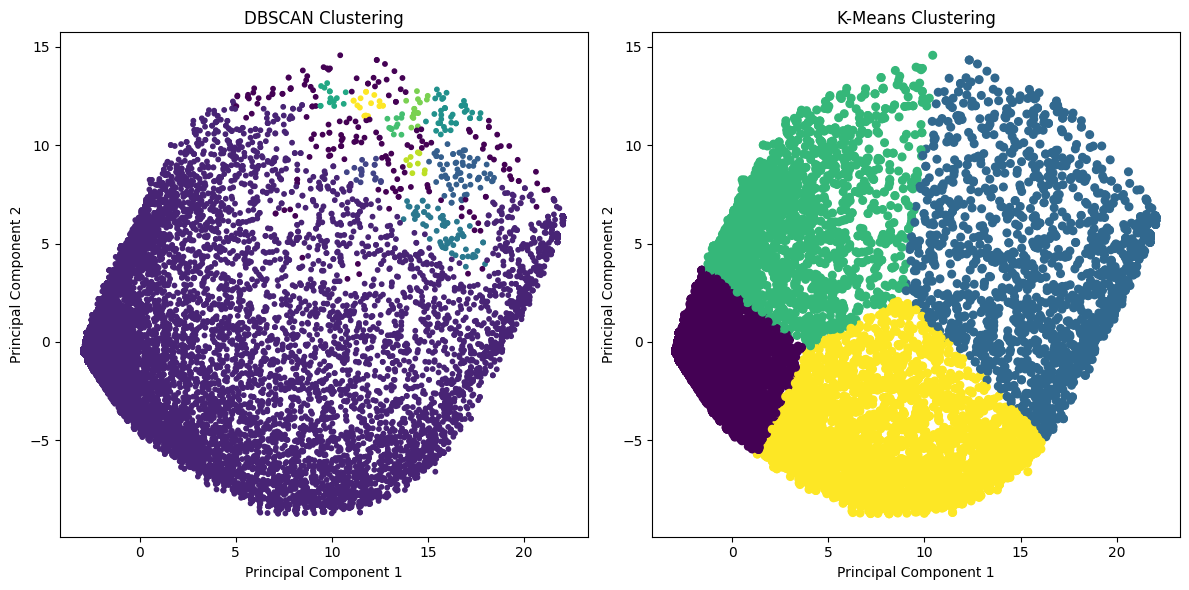

In [171]:
# Plot DBSCAN
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels_pca, cmap='viridis', s=10)
plt.title("DBSCAN Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot K-Means
plt.subplot(1, 2, 2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels_pca, cmap='viridis', s=30)
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


**Evaluate clustering quality for DBSCAN and K-means**


Silhouette Score for DBSCAN: 0.6041107150909613

Silhouette Score for K-Means: 0.6829698895893928

Davies-Bouldin Index for DBSCAN: 2.0325286388484876
Davies-Bouldin Index for K-Means: 0.6929537006089861


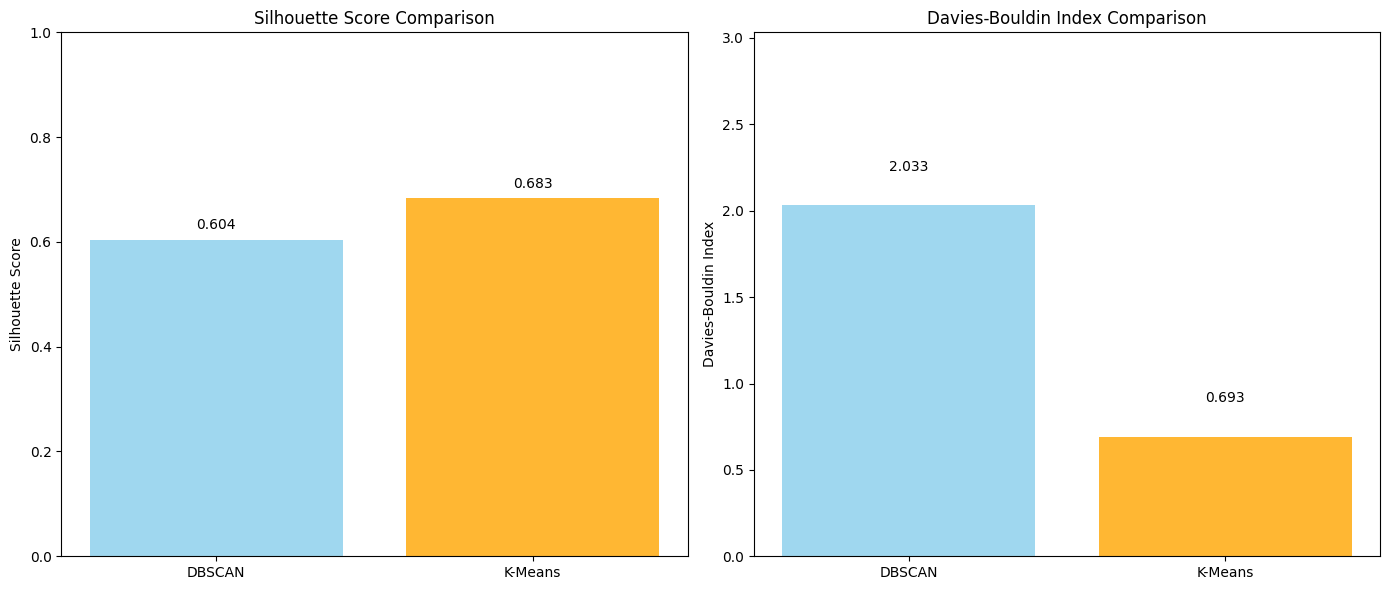

In [172]:
# Evaluate clustering quality

print("\nSilhouette Score for DBSCAN:", silhouette_score(reduced_data, dbscan_labels_pca))
print("\nSilhouette Score for K-Means:", silhouette_score(reduced_data, kmeans_labels_pca))

print("\nDavies-Bouldin Index for DBSCAN:", davies_bouldin_score(reduced_data, dbscan_labels_pca))
print("Davies-Bouldin Index for K-Means:", davies_bouldin_score(reduced_data, kmeans_labels_pca))

# Values from the metrics
silhouette_scores = [
    silhouette_score(reduced_data, dbscan_labels_pca),
    silhouette_score(reduced_data, kmeans_labels_pca)
]
davies_bouldin_indices = [
    davies_bouldin_score(reduced_data, dbscan_labels_pca),
    davies_bouldin_score(reduced_data, kmeans_labels_pca)
]

# Labels for the algorithms
labels = ['DBSCAN', 'K-Means']

# Create a bar chart for Silhouette Scores
plt.figure(figsize=(14, 6))

# Silhouette Score Bar Plot
plt.subplot(1, 2, 1)
plt.bar(labels, silhouette_scores, color=['skyblue', 'orange'], alpha=0.8)
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)  # Silhouette Score ranges from -1 to 1
for i, score in enumerate(silhouette_scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', fontsize=10)

# Davies-Bouldin Index Bar Plot
plt.subplot(1, 2, 2)
plt.bar(labels, davies_bouldin_indices, color=['skyblue', 'orange'], alpha=0.8)
plt.title('Davies-Bouldin Index Comparison')
plt.ylabel('Davies-Bouldin Index')
plt.ylim(0, max(davies_bouldin_indices) + 1)  # Adjust y-limit for clarity
for i, dbi in enumerate(davies_bouldin_indices):
    plt.text(i, dbi + 0.2, f"{dbi:.3f}", ha='center', fontsize=10)

# Display the plots
plt.tight_layout()
plt.show()



**Visualization of Noise Points from DBSCAN Clustering: States with Endangered Plant Species**

In [173]:
# Add DBSCAN labels to the dataset
plants_data_cleaned['DBSCAN_Label'] = dbscan_labels_pca

# Filter for noise points (DBSCAN label = -1)
noise_points = plants_data_cleaned[plants_data_cleaned['DBSCAN_Label'] == -1]

# Extract and count states from noise points
def count_states(states_column):
    state_counts = {}
    for states in states_column:
        for state in states.split(','):
            state_counts[state] = state_counts.get(state, 0) + 1
    return state_counts

state_counts = count_states(noise_points['States'])
state_counts_df = pd.DataFrame(list(state_counts.items()), columns=['State', 'Noise_Count'])


# Map two-letter state codes to full names for Plotly
state_abbr_to_full = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming", "PR": "Puerto Rico",
    "VI": "Virgin Islands"
}

state_counts_df['State'] = state_counts_df['State'].str.upper()
state_counts_df['State_Full'] = state_counts_df['State'].map(state_abbr_to_full)

valid_states = set(state_abbr_to_full.keys())
state_counts_df = state_counts_df[state_counts_df['State'].isin(valid_states)]
missing_states = state_counts_df[state_counts_df['State_Full'].isnull()]['State'].unique()

# Create the interactive map
fig = px.choropleth(
    state_counts_df,
    locations='State',  # Use two-letter state abbreviations
    locationmode='USA-states',
    color='Noise_Count',  # Color by noise point counts
    hover_name='State_Full',  # Full state names for hover info
    title='States with Endangered Plant Species (Noise Points)',
    scope='usa',
    color_continuous_scale="Reds"
)

fig.show()


**Visualization of Most Found Plants using K-Means Clustering**

<ipython-input-174-456bb6a14ea0>:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.




Most Found Plant in Each Cluster:
   Cluster            Most_Common_Plant  Num_States
0        0                         nama          22
1        1                   eleocharis          69
2        2  callitriche hermaphroditica          37
3        3                     ludwigia          52

Overall Most Found Plant:
Plant Name    eleocharis
Num_States            69
Name: 11724, dtype: object


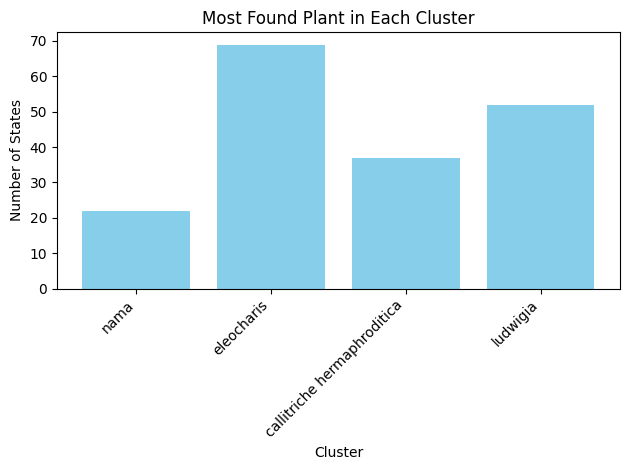

In [174]:
# Add K-means labels to the dataset
plants_data_cleaned['K-MEANS_Label'] = kmeans_labels_pca

# Calculate the number of states for each plant
plants_data_cleaned['Num_States'] = plants_data_cleaned['States'].apply(lambda x: len(x.split(',')))

# Find the most found plant in each cluster
most_common_plants = plants_data_cleaned.groupby('K-MEANS_Label').apply(
    lambda x: x.loc[x['Num_States'].idxmax(), ['Plant Name', 'Num_States']]
).reset_index()

# Rename columns for clarity
most_common_plants.columns = ['Cluster', 'Most_Common_Plant', 'Num_States']

# Display the most common plant in each cluster
print("\nMost Found Plant in Each Cluster:")
print(most_common_plants)

# Find the overall most found plant
overall_most_common = plants_data_cleaned.loc[plants_data_cleaned['Num_States'].idxmax()]
print("\nOverall Most Found Plant:")
print(overall_most_common[['Plant Name', 'Num_States']])

# Bar chart for the most common plants in each cluster
plt.bar(most_common_plants['Cluster'], most_common_plants['Num_States'], color='skyblue')
plt.xticks(most_common_plants['Cluster'], most_common_plants['Most_Common_Plant'], rotation=45, ha='right')
plt.title('Most Found Plant in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of States')
plt.tight_layout()
plt.show()


# Extract the states for the overall most found plant
overall_states = overall_most_common['States'].split(',')
state_counts = pd.DataFrame({'State': overall_states, 'Count': [1] * len(overall_states)})

# Convert state abbreviations to uppercase
state_counts['State'] = state_counts['State'].str.upper()

# Filter for valid U.S. state codes
valid_states = set([
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
    'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
    'WI', 'WY'
])
state_counts = state_counts[state_counts['State'].isin(valid_states)]

# Plot the map
fig = px.choropleth(
    state_counts,
    locations='State',
    locationmode='USA-states',
    color='Count',
    title=f"Geographic Distribution of {overall_most_common['Plant Name']}",
    scope='usa',
    color_continuous_scale="Greens"
)
fig.show()


